# Sunspots - Analysis

In [81]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from dateutil.parser import parse

## Importing data

In [76]:
df = pd.read_csv('Sunspots.csv', parse_dates=['Date'], index_col='Date')['Monthly Mean Total Sunspot Number']
df.head()

Date
1749-01-31     96.7
1749-02-28    104.3
1749-03-31    116.7
1749-04-30     92.8
1749-05-31    141.7
Name: Monthly Mean Total Sunspot Number, dtype: float64

## Visualizing Sunspots Time Series Data

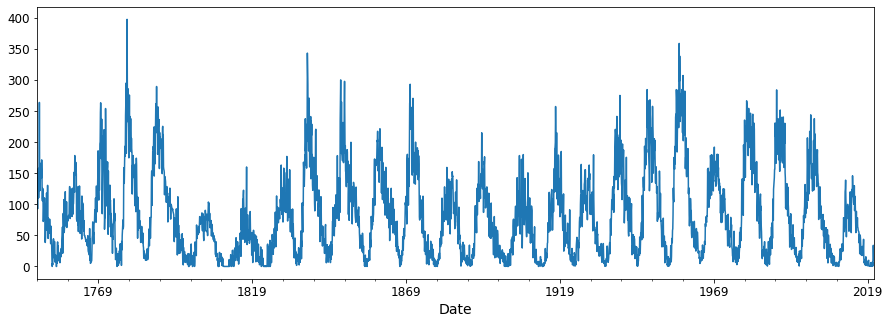

In [9]:
df.plot(figsize=(15,5))
plt.show()

## Testing for Stationarity

There are multiple implementations of Unit Root tests like:

Augmented Dickey Fuller test (ADH Test)
Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)
Philips Perron test (PP Test)
The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, id the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis.

In [87]:
# ADF Test
result = adfuller(df, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -10.497051662546154
p-value: 1.1085524921955702e-18
Critial Values:
   1%, -3.4323724026124003
Critial Values:
   5%, -2.8624335760905684
Critial Values:
   10%, -2.5672456699774324

KPSS Statistic: 0.103805
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


### Another possibility

In [88]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(120).mean() 
    rolstd = timeseries.rolling(120).std()
    
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

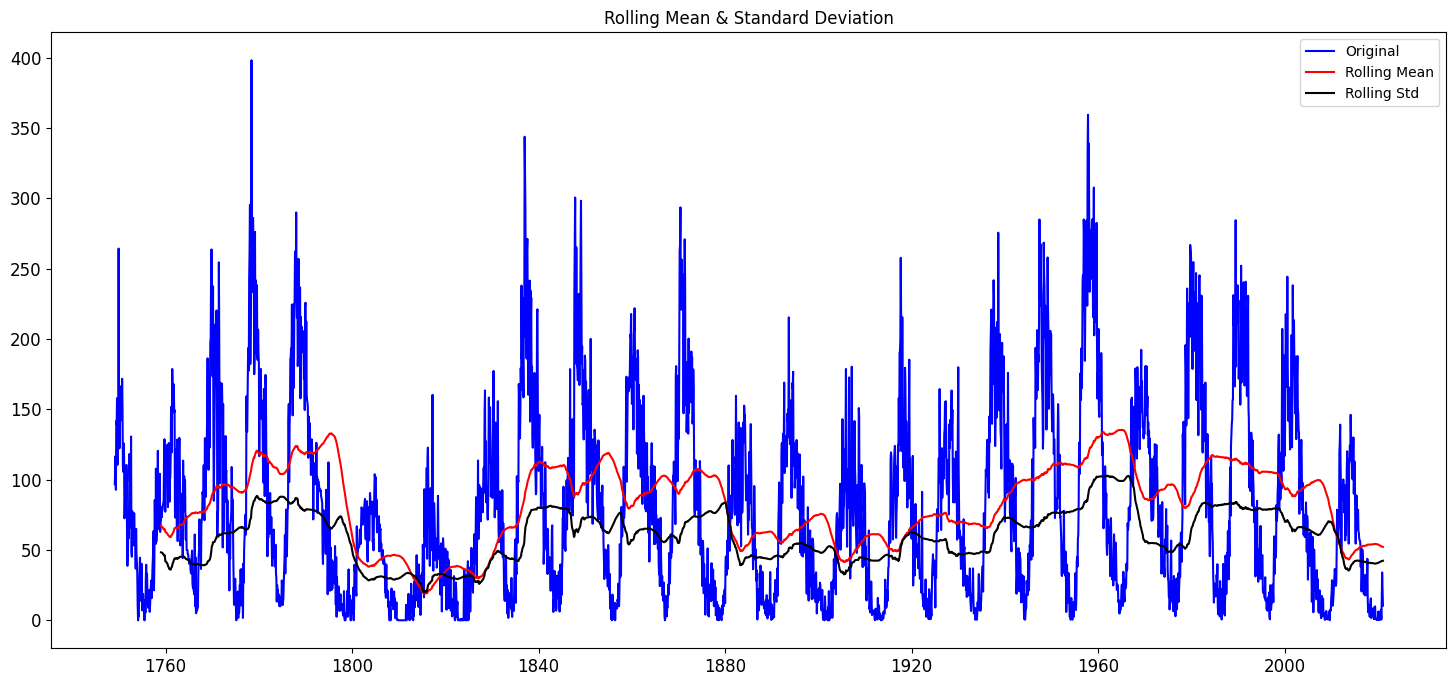

Results of Dickey-Fuller Test:
Test Statistic                -1.049705e+01
p-value                        1.108552e-18
#Lags Used                     2.800000e+01
Number of Observations Used    3.236000e+03
Critical Value (1%)           -3.432372e+00
Critical Value (5%)           -2.862434e+00
Critical Value (10%)          -2.567246e+00
dtype: float64


In [89]:
test_stationarity(df)

####  <span style="color:red">It's  best to leave a graph with the rolling mean and the standard deviation?</span>
    
note: to calculate the rolling mean and the standard deviation, I've used the time period (k) as 120 months since the data appears to have 10 year cycles. 

## Time Series Decomposition

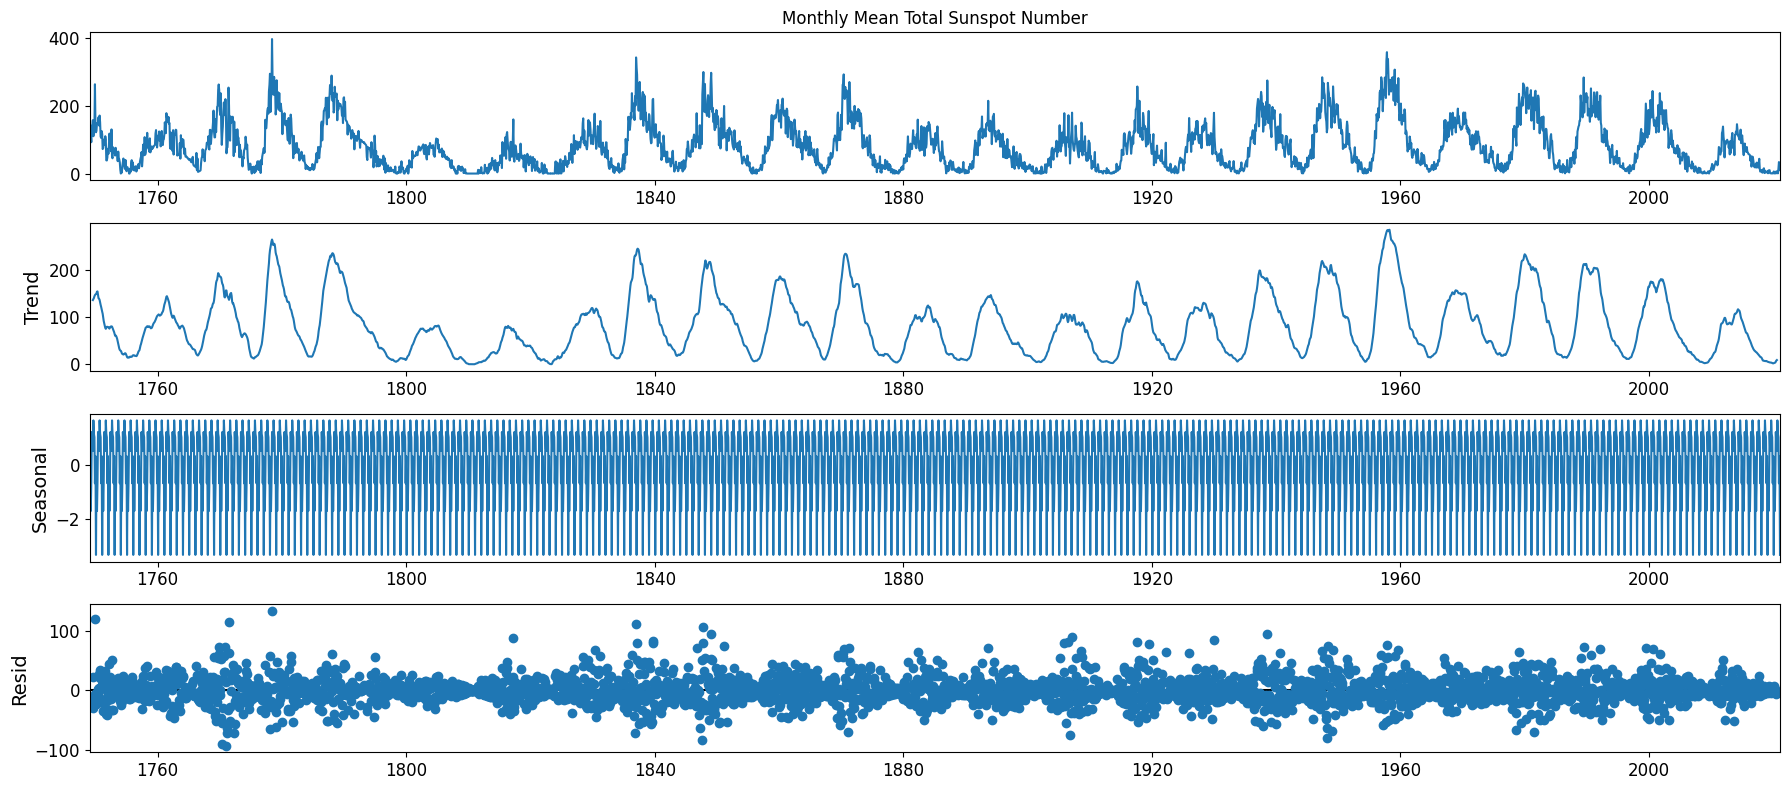

In [68]:
matplotlib.rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

# Forecasts

In [153]:
# Split time series data into training and test set

train_data = int(len(df)*0.8)

train = df[0: train_data] # train with the first 80% of the data
test = df[train_data:] # test with the last 20% of the data

In [158]:
# function evaluate forecast accuracy 

def calculate_error(test_data, model_data):
    
    rmse = np.sqrt(np.mean((test_data - model_data)**2)).round(2)
    mae = np.mean(np.abs(test_data - model_data)).round(2) 
    mape = np.mean((np.abs(test_data - model_data) / test_data)*100).round(2)

    return print(f"RMSE: {rmse} \nMAE: {mae} \nMAPE: {mape}")

### 1. Mean Model

#### Add notes

In [141]:
y_hat_mean = test.copy()
y_hat_mean = y_hat_mean.apply(lambda x: df.mean())

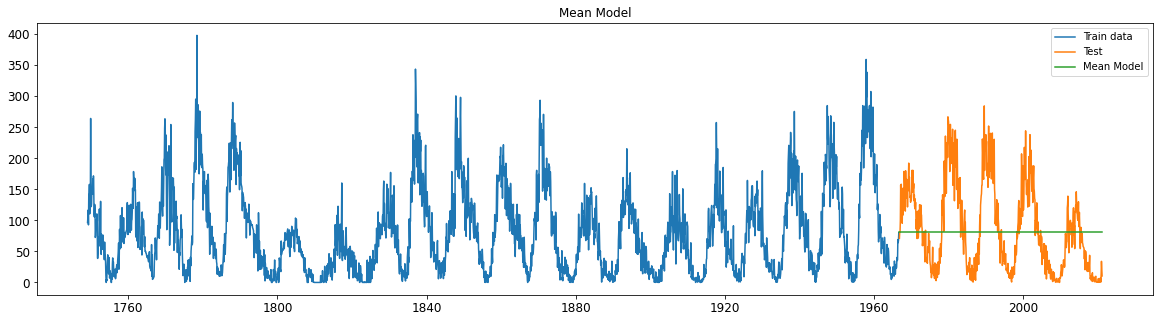

In [155]:
# Plotting the Mean Model Graph

plt.figure(figsize=(20,5))
plt.title('Mean Model')
plt.plot(train, label='Train data')
plt.plot(test, label='Test')
plt.plot(y_hat_mean, label='Mean Model')
plt.legend(loc='best')
plt.show()

#### Calculating RMSE and MAPE

In [148]:
calculate_error(test, y_hat_mean)

RMSE: 69.44 
MAE: 58.36 
MAPE: inf


### 2. Exponencial smoothing

In [131]:
fit_1 = SimpleExpSmoothing(train).fit(smoothing_level=0.2)
fit_2 = SimpleExpSmoothing(train).fit(smoothing_level=0.6)
fit_3 = SimpleExpSmoothing(train).fit()

In [132]:
fcast_1 = fit_1.forecast(653)
fcast_2 = fit_2.forecast(653)
fcast_3 = fit_3.forecast(653)

In [149]:
calculate_error(test, fcast_1)

RMSE: 75.02 
MAE: 58.98 
MAPE: inf


In [150]:
calculate_error(test, fcast_2)

RMSE: 70.58 
MAE: 57.97 
MAPE: inf


In [151]:
calculate_error(test, fcast_3)

RMSE: 70.74 
MAE: 57.97 
MAPE: inf


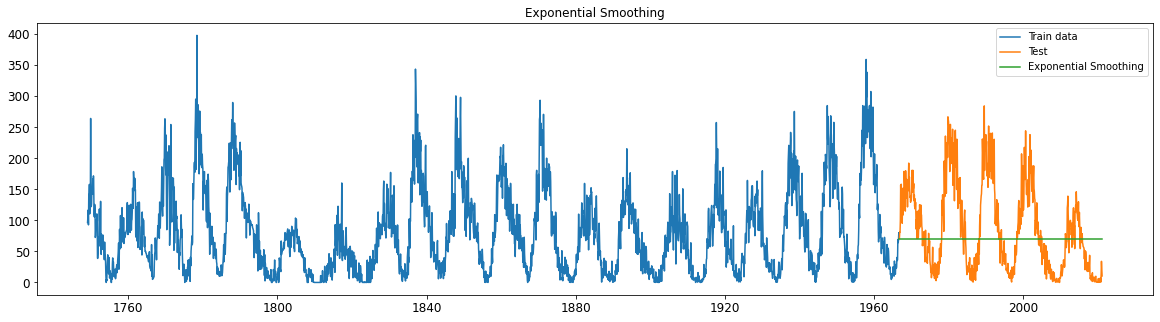

In [130]:
# Plotting the Exponential Smoothing Graph

plt.figure(figsize=(20,5))
plt.title('Exponential Smoothing')
plt.plot(train, label='Train data')
plt.plot(test, label='Test')
plt.plot(fcast_1, label='Exponential Smoothing')
plt.legend(loc='best')
plt.show()

# Rascunho

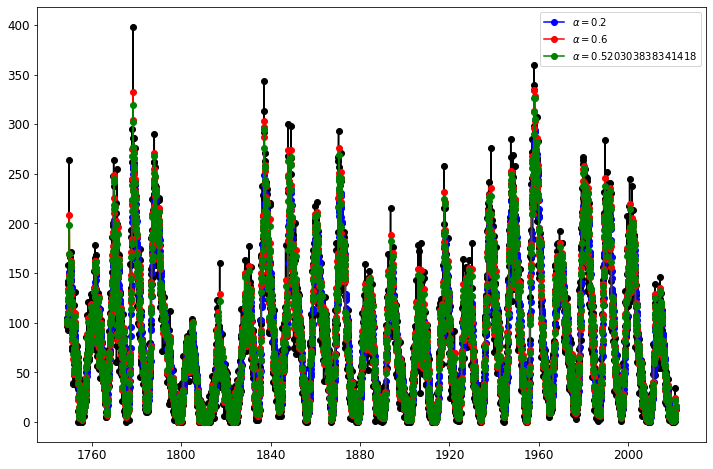

In [80]:
fit1 = SimpleExpSmoothing(df, initialization_method="heuristic").fit(smoothing_level=0.2, optimized=False)

fcast1 = fit1.forecast(3).rename(r"$\alpha=0.2$")

fit2 = SimpleExpSmoothing(df, initialization_method="heuristic").fit(smoothing_level=0.6, optimized=False)
fcast2 = fit2.forecast(3).rename(r"$\alpha=0.6$")

fit3 = SimpleExpSmoothing(df, initialization_method="estimated").fit()
fcast3 = fit3.forecast(3).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])

plt.figure(figsize=(12, 8))
plt.plot(df, marker="o", color="black")
plt.plot(fit1.fittedvalues, marker="o", color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(fit2.fittedvalues, marker="o", color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(fit3.fittedvalues, marker="o", color="green")
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

In [160]:
for i in [0 , 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90,1]:
    print(f'Fitting for smoothing level= {i}')
    fit_v = SimpleExpSmoothing(np.asarray(train)).fit(i)
    fcst_pred_v= fit_v.forecast(30)
    timeseries_evaluation_metrics_func(test,fcst_pred_v)
    rmse = np.sqrt(metrics.mean_squared_error(test, fcst_pred_v))
    df3 = {'smoothing parameter':i, 'RMSE': rmse}
    temp_df = temp_df.append(df3, ignore_index=True)
temp_df.sort_values(by=['RMSE']).head(3)

AttributeError: 'numpy.float64' object has no attribute 'plot'

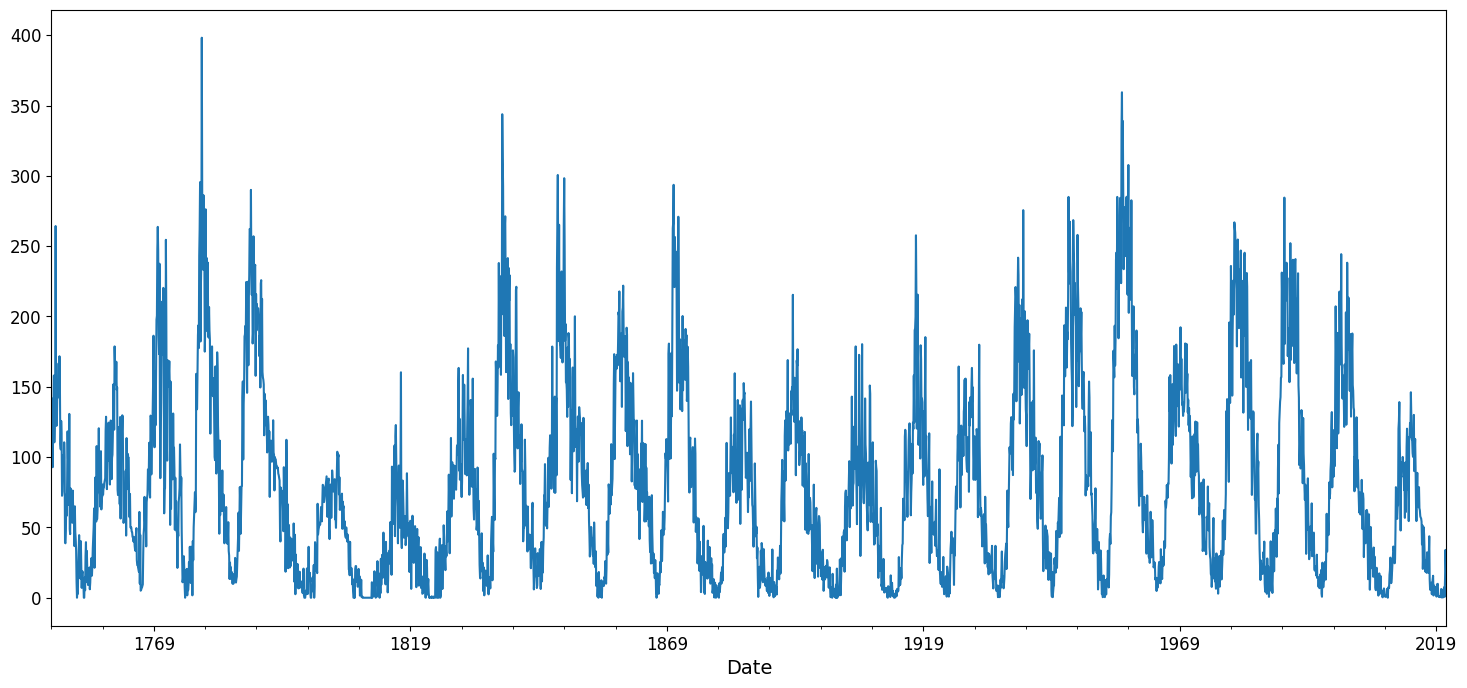

In [77]:
#pred = results.get_prediction(start=pd.to_datetime('1966-01-31'), dynamic=False)
#pred_ci = pred.conf_int()
ax = df.plot(label='observed')

dm = df.mean()
dm.plot(ax=ax, label='Dummy Model', alpha=.7, figsize=(14, 7))
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Mean Total Sunspot Number')
plt.legend()
plt.show()

### Time series forecasting with ARIMA

In [54]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [55]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

#### <span style="color:red">não consegui rodar a otimização, vou chutar um número para as análises abaixo </span>

In [56]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.84246D+00    |proj g|=  5.04686D-01

At iterate    5    f=  4.81833D+00    |proj g|=  4.29838D-02

At iterate   10    f=  4.81720D+00    |proj g|=  2.55226D-02

At iterate   15    f=  4.80884D+00    |proj g|=  6.52484D-02

At iterate   20    f=  4.80335D+00    |proj g|=  1.18396D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     27      1     0     0   4.347D-06   4.803D+00
  F =   4.8033516745018918     

CONVERG

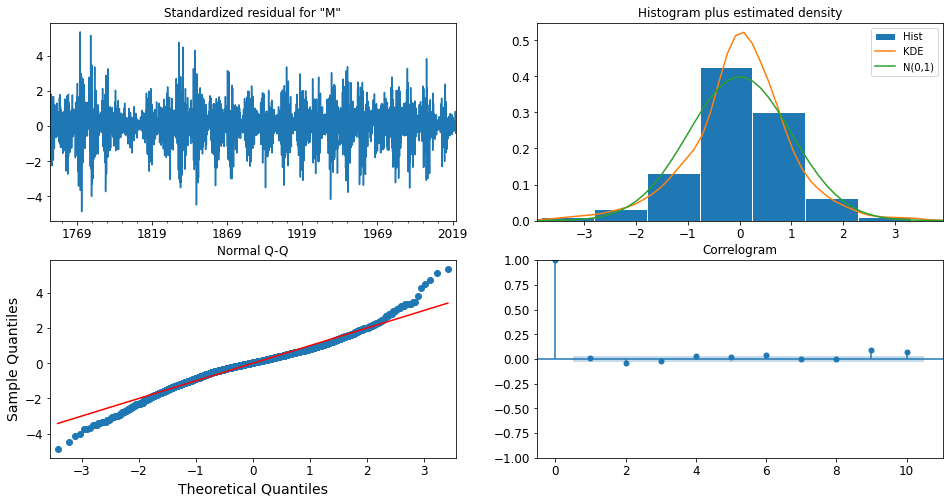

In [57]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Validating forecasts

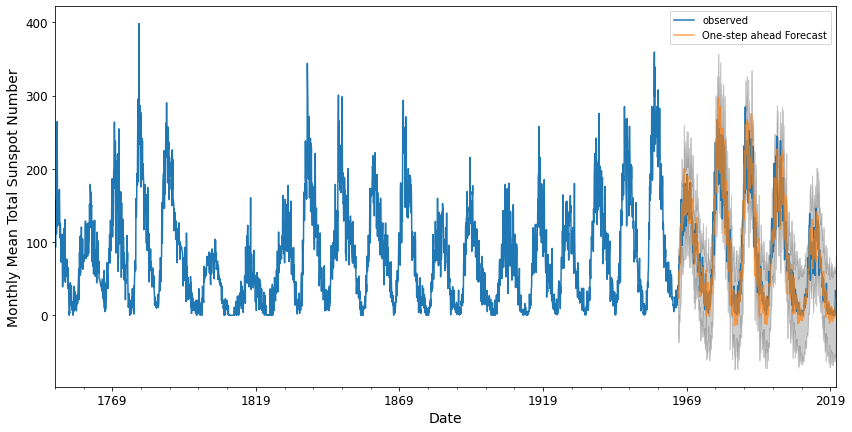

In [34]:
pred = results.get_prediction(start=pd.to_datetime('1966-01-31'), dynamic=False)
pred_ci = pred.conf_int()
ax = df.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Mean Total Sunspot Number')
plt.legend()
plt.show()

In [35]:
df_forecasted = pred.predicted_mean
df_truth = df['1996-01-31':]
mse = ((df_forecasted - df_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 596.02


In [36]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 24.41


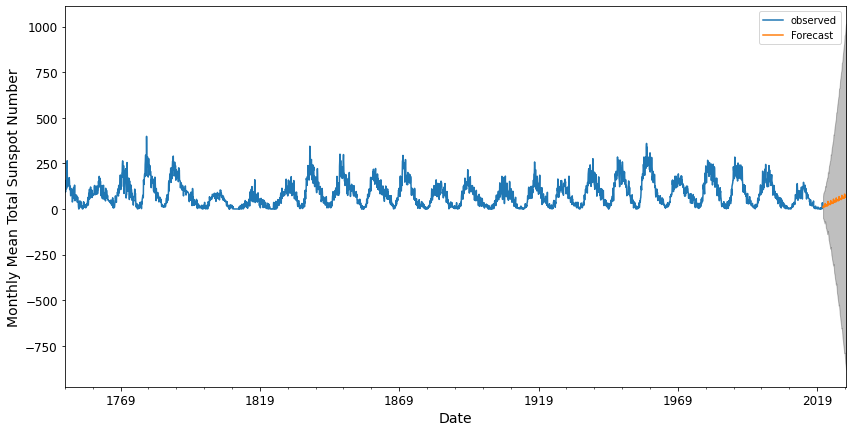

In [38]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = df.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Mean Total Sunspot Number')
plt.legend()
plt.show()

####  <span style="color:red">Acho que deu ruim aqui</span>

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

# Bibliography

* Hyndman, R. J., & Koehler, A. B. (2006). Another look at measures of forecast accuracy. International Journal of Forecasting, 22(4), 679–688. [DOI]
* Forecasting: principles and practice, 2013.